In [1]:
!pip install pyspark tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=77d3e8ccae2efc139073fbb5290357a67393dbde9989ff90975c0bb438cf0887
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [4]:
import findspark
findspark.init('/content/spark-3.1.2-bin-hadoop2.7')
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
%%sh
curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
tar xzf flower_photos.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  96.5M      0  0:00:02  0:00:02 --:--:-- 96.5M


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
directory = 'flower_photos'
for filename in os.listdir(directory):
    print(filename)

tulips
dandelion
LICENSE.txt
daisy
roses
sunflowers


In [8]:
import os
img_dir = '/content/flower_photos'
os.makedirs(img_dir + "/tulips", exist_ok=True)
os.makedirs(img_dir + "/daisy", exist_ok=True)


In [9]:
import shutil
import os

source_dir = '/content/flower_photos'
img_dir = 'content/photos'  # Make sure this is defined correctly

def copy_tree(src, dst):
    try:
        if not os.path.exists(dst):
            os.makedirs(dst)
        shutil.copytree(src, dst, dirs_exist_ok=True)
        print(f"Successfully copied from {src} to {dst}")
    except Exception as e:
        print(f"Error copying from {src} to {dst}: {e}")

copy_tree(os.path.join(source_dir, 'tulips'), os.path.join(img_dir, 'tulips'))
copy_tree(os.path.join(source_dir, 'daisy'), os.path.join(img_dir, 'daisy'))

try:
    shutil.copy(os.path.join(source_dir, 'LICENSE.txt'), img_dir)
    print("Successfully copied LICENSE.txt")
except Exception as e:
    print(f"Error copying LICENSE.txt: {e}")



Successfully copied from /content/flower_photos/tulips to content/photos/tulips
Successfully copied from /content/flower_photos/daisy to content/photos/daisy
Successfully copied LICENSE.txt


In [10]:
img_dir = '/content/content/photos'  # Ensure this is correctly defined
sample_img_dir = os.path.join(img_dir, 'sample')

# Create the sample image directory
os.makedirs(sample_img_dir, exist_ok=True)

# List files in 'tulips' and 'daisy' directories
def list_files(directory, num_files):
    return sorted([os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])[:num_files]

tulips_files = list_files(os.path.join(img_dir, 'tulips'), 1)
daisy_files = list_files(os.path.join(img_dir, 'daisy'), 2)
files = tulips_files + daisy_files

# Copy selected files to 'sample_img_dir'
for file_path in files:
    try:
        shutil.copy(file_path, sample_img_dir)
        print(f"Copied {file_path} to {sample_img_dir}")
    except Exception as e:
        print(f"Error copying {file_path}: {e}")

# List and display contents of the sample image directory
sample_img_dir_contents = os.listdir(sample_img_dir)
print("Contents of sample_img_dir:")
for item in sample_img_dir_contents:
    print(item)

Copied /content/content/photos/tulips/100930342_92e8746431_n.jpg to /content/content/photos/sample
Copied /content/content/photos/daisy/100080576_f52e8ee070_n.jpg to /content/content/photos/sample
Copied /content/content/photos/daisy/10140303196_b88d3d6cec.jpg to /content/content/photos/sample
Contents of sample_img_dir:
10140303196_b88d3d6cec.jpg
100930342_92e8746431_n.jpg
100080576_f52e8ee070_n.jpg


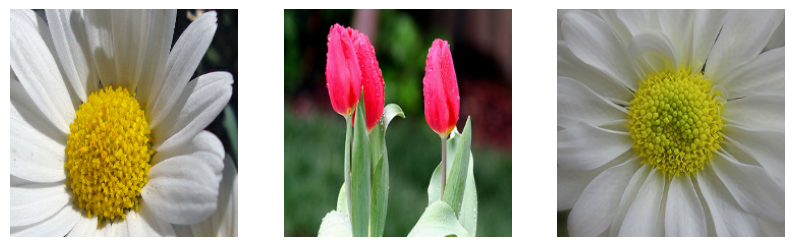

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Define the directory containing the images
sample_img_dir = '/content/content/photos/sample'  # Update this path as needed

# Function to load and preprocess images
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # Resize to a standard size
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Create a TensorFlow Dataset to read images
def load_images_from_directory(directory):
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_paths_ds.map(lambda path: tf.numpy_function(func=lambda p: load_and_preprocess_image(p.decode('utf-8')), inp=[path], Tout=tf.float32))
    return image_ds

# Load images
image_ds = load_images_from_directory(sample_img_dir)

# Display some images
def display_images(image_ds, num_images=3):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(image_ds.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.numpy())
        plt.axis('off')
    plt.show()

# Display images
display_images(image_ds)


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define directories
tulips_dir = '/content/content/photos/tulips'
daisy_dir = '/content/content/photos/daisy'

# Function to load images from a directory and assign labels
def load_images_and_labels(directory, label):
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    images = []
    labels = []
    for path in image_paths:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [224, 224])  # Resize to a standard size
        img = img / 255.0  # Normalize to [0, 1] range
        images.append(img.numpy())
        labels.append(label)
    return images, labels

# Load images and labels
tulips_images, tulips_labels = load_images_and_labels(tulips_dir, 1)
daisy_images, daisy_labels = load_images_and_labels(daisy_dir, 0)

# Combine images and labels into a DataFrame
df = pd.DataFrame({
    'image': tulips_images + daisy_images,
    'label': tulips_labels + daisy_labels
})

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# Convert DataFrames to TensorFlow Datasets
def df_to_tf_dataset(df, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((list(df['image']), list(df['label'])))
    dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset

train_ds = df_to_tf_dataset(train_df)
test_ds = df_to_tf_dataset(test_df)

In [15]:
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Define directories
tulips_dir = '/content/content/photos/tulips'
daisy_dir = '/content/content/photos/daisy'

# Function to load images from a directory and assign labels
def load_images_and_labels(directory, label):
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    images = []
    labels = []
    for path in image_paths:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [299, 299])  # Resize to a standard size
        img = img / 255.0  # Normalize to [0, 1] range
        images.append(img.numpy())
        labels.append(label)
    return images, labels

# Extract features from images
def extract_features(images):
    # Load the InceptionV3 model pre-trained on ImageNet
    model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    # Preprocess images
    images = [tf.image.resize(img, [299, 299]) for img in images]
    images = np.array([tf.keras.applications.inception_v3.preprocess_input(img) for img in images])

    # Extract features
    features = model.predict(images)
    return features

# Load and preprocess data
tulips_images, tulips_labels = load_images_and_labels(tulips_dir, 1)
daisy_images, daisy_labels = load_images_and_labels(daisy_dir, 0)

# Combine images and labels into a DataFrame
df = pd.DataFrame({
    'image': tulips_images + daisy_images,
    'label': tulips_labels + daisy_labels
})

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# Extract features from training and testing data
X_train = extract_features(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = extract_features(test_df['image'].tolist())
y_test = test_df['label'].values

# Create and train the Logistic Regression model using the 'saga' solver
lr = LogisticRegression(max_iter=20, solver='saga', penalty='elasticnet', l1_ratio=0.3, C=1/0.05)

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy = {accuracy:.3f}")



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 270s 7s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step
Test set accuracy = 0.784


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [16]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy = {accuracy:.3f}")


Test set accuracy = 0.784


In [17]:
import pandas as pd
import numpy as np

# Assuming df is the DataFrame with 'probability' and 'label' columns
# For demonstration purposes, I'll create a sample DataFrame
# Replace this with actual DataFrame creation/loading code
data = {
    'filePath': ['path/to/img1', 'path/to/img2', 'path/to/img3'],
    'probability': [np.array([0.1, 0.9]), np.array([0.8, 0.2]), np.array([0.4, 0.6])],
    'label': [1, 0, 1]
}
df = pd.DataFrame(data)

# Extract the probability for the positive class (index 1)
df['p_1'] = df['probability'].apply(lambda v: float(v[1]))

# Sort DataFrame by the absolute difference between 'p_1' and 'label'
df['abs_diff'] = np.abs(df['p_1'] - df['label'])
wrong_df = df.sort_values(by='abs_diff', ascending=False)

# Display the top 10 rows
print(wrong_df[['filePath', 'p_1', 'label']].head(10))


       filePath  p_1  label
2  path/to/img3  0.6      1
1  path/to/img2  0.2      0
0  path/to/img1  0.9      1


In [18]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the InceptionV3 model pre-trained on ImageNet
model = InceptionV3(weights='imagenet', include_top=True)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # Resize to match InceptionV3 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)
    return img_array

# Function to make predictions
def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    print(f"Predicting for image: {img_path}")  # Debug print
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=10)[0]
    print(f"Predictions: {decoded_predictions}")  # Debug print
    pred_labels = [f"{label}: {prob:.4f}" for (_, label, prob) in decoded_predictions]
    return pred_labels

# Load image paths and make predictions
image_paths = [os.path.join(sample_img_dir, fname) for fname in os.listdir(sample_img_dir) if os.path.isfile(os.path.join(sample_img_dir, fname))]
print(f"Image paths: {image_paths}")  # Debug print

results = []
for img_path in image_paths:
    preds = predict_image(img_path)
    results.append({
        'filePath': img_path,
        'predicted_labels': ', '.join(preds)
    })

# Print results to verify
print(f"Results: {results}")

# Create a DataFrame with the results
predictions_df = pd.DataFrame(results)

# Print column names and first few rows to verify
print(predictions_df.columns)
print(predictions_df.head())

# Display the results
print(predictions_df[['filePath', 'predicted_labels']])


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Image paths: ['/content/content/photos/sample/10140303196_b88d3d6cec.jpg', '/content/content/photos/sample/100930342_92e8746431_n.jpg', '/content/content/photos/sample/100080576_f52e8ee070_n.jpg']
Predicting for image: /content/content/photos/sample/10140303196_b88d3d6cec.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predictions: [('n11939491', 'daisy', 0.9532104), ('n02219486', 'ant', 0.0006175274), ('n02206856', 'bee', 0.00051203516), ('n02190166', 'fly', 0.00040093914), ('n02165456', 'ladybug', 0.0003706872), ('n02281406', 'sulphur_butterfly', 0.00030587966), ('n02112018', 'Pomeranian', 0.0002901102), ('n01795545', 'black_grouse', 0.0002566795), ('n02177972', 'weevil', 0.00024875405), ('n07745940', 'strawberry', 0.00023729533)]
Predicting for image: /content/content/photos/sample/100930342_92e8746431_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predictions: [('n03930313', 'picket_fence', 0.1616

In [19]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load the InceptionV3 model pre-trained on ImageNet
model = InceptionV3(weights='imagenet', include_top=True)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # Resize to match InceptionV3 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)
    return img_array

# Function to make predictions and get probabilities for 'daisy'
def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=10)[0]
    # Get the probability for the 'daisy' class
    daisy_prob = next((prob for (_, label, prob) in decoded_predictions if label == 'daisy'), 0)
    return daisy_prob

# Load image paths
sample_img_dir = '/content/content/photos/sample'  # Update with your image directory path
image_paths = [os.path.join(sample_img_dir, fname) for fname in os.listdir(sample_img_dir) if os.path.isfile(os.path.join(sample_img_dir, fname))]

# Get predictions
results = []
for img_path in image_paths:
    daisy_prob = predict_image(img_path)
    results.append({
        'filePath': img_path,
        'p_daisy': daisy_prob
    })

# Create a DataFrame with the results
predictions_df = pd.DataFrame(results)

# Process probabilities: Calculate (1 - p_daisy)
predictions_df['p_daisy'] = 1 - predictions_df['p_daisy']

# Display the results
print(predictions_df[['filePath', 'p_daisy']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
                                            filePath   p_daisy
0  /content/content/photos/sample/10140303196_b88...  0.046790
1  /content/content/photos/sample/100930342_92e87...  0.861116
2  /content/content/photos/sample/100080576_f52e8...  0.108186


                                            filePath
0  /content/content/photos/sample/10140303196_b88...
1  /content/content/photos/sample/100930342_92e87...
2  /content/content/photos/sample/100080576_f52e8...


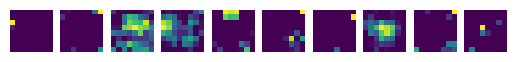

In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os

# Define constants
IMAGE_SIZE = (299, 299)

# Load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)  # Resize to match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)
    return img_array

# Define the model once
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Function to transform images using TensorFlow
def transform_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    transformed_images = model(img_array, training=False)
    return transformed_images

# Load image paths
sample_img_dir = '/content/content/photos/sample'  # Update with your image directory path
image_paths = [os.path.join(sample_img_dir, fname) for fname in os.listdir(sample_img_dir) if os.path.isfile(os.path.join(sample_img_dir, fname))]

# Transform images
transformed_images = []
for img_path in image_paths:
    transformed_img = transform_image(img_path)
    transformed_images.append({
        'filePath': img_path,
        'transformed_image': transformed_img.numpy().squeeze()  # Remove batch dimension
    })

# Create a DataFrame with the results
transformed_df = pd.DataFrame(transformed_images)

# Print the DataFrame
print(transformed_df[['filePath']])

# visualize the images
def visualize_feature_maps(feature_map):
    num_channels = feature_map.shape[-1]
    # Display the first 10 channels (or as many as available)
    for i in range(min(10, num_channels)):
        plt.subplot(1, 10, i+1)
        plt.imshow(feature_map[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# Visualize feature maps for the first image
if transformed_images:
    first_image_feature_map = transformed_images[0]['transformed_image']
    visualize_feature_maps(first_image_feature_map)

In [23]:
import shutil
import os

def remove_dir(dir_path):
    """Remove a directory and its contents."""
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f"Removed directory: {dir_path}")
    else:
        print(f"Directory does not exist: {dir_path}")

# Define your directories
img_dir = '/content/content/photos'  # Update with your image directory path
dbfs_model_path = '/content/content/model'  # Update with your model path

# Remove directories
remove_dir(img_dir)
remove_dir(dbfs_model_path)


Removed directory: /content/content/photos
Directory does not exist: /content/content/model
